In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import polars as pl

In [35]:
rng: np.random.Generator = np.random.default_rng(seed=1227)

## Impact of New Arms on Exploration

### Problem Setup

We have a **dynamic Bernoulli multi-armed bandit** where arms can appear at different points in time.

* Let there be an initial set of $K_0$ arms with unknown but fixed success probabilities
  $\theta_0 = (\theta_{0,1}, \theta_{0,2}, \dots, \theta_{0,K_0}), \qquad \theta_{0,k} \in (0,1).$

* At specific times $t \in \mathcal{T}_{\text{arrivals}}$, we introduce one or more new arms.
  For a new arm $j$ arriving at time $t_0$, we assign it a true mean reward $\theta_j$.

Thus, at any time $t$, the set of available arms is:

$$
\mathcal{A}(t) = \{1,\dots,K_0\} \cup \bigcup_{t_0 \leq t} \mathcal{A}_{\text{new}}(t_0)
$$

where $\mathcal{A}_{\text{new}}(t_0)$ is the set of new arms introduced at $t_0$.

1. **Outer union (`U` with the initial set)**

   * The first `U` is just a simple set union between two sets:

     * The set of indices of the original $K_0$ arms:
       $\{1, 2, \dots, K_0\}$

     * The set of all new arms that have arrived up to time $t$:
       $\bigcup_{t_0 \leq t} \mathcal{A}_{\text{new}}(t_0)$

   This ensures that $\mathcal{A}(t)$ includes both initial and newly arrived arms.

2. **Inner union ($\bigcup_{t_0 \leq t}$)**

   * This is a **union over time indices**. It collects all sets of arms that have arrived at each arrival time $t_0$ **up to time $t$**:

     $$
     \bigcup_{t_0 \leq t} \mathcal{A}_{\text{new}}(t_0)
     = \mathcal{A}_{\text{new}}(t_1) \cup \mathcal{A}_{\text{new}}(t_2) \cup \dots \cup \mathcal{A}_{\text{new}}(t_m)
     $$

     where $t_1, t_2, \dots, t_m$ are all the arrival times such that $t_i \leq t$.

   Intuition: this aggregates the **history of arrivals** into one set.

So we have:

* **Inner union** = "collect all newly added arms that have arrived up to $t$"
* **Outer union** = "combine those with the initial set of arms"

---

### Thompson Sampling Algorithm

We use **Thompson Sampling (TS)** with independent Beta priors for each arm.

* **Prior:** for arm $k$,

$$
\theta_k \sim \mathrm{Beta}(\alpha_0, \beta_0)
$$

* **Posterior update:** after pulling arm $k$ at time $t$ and observing reward $r_t \in {0,1}$, we update:

$$
\alpha_k \leftarrow \alpha_k + r_t, \qquad 
\beta_k \leftarrow \beta_k + (1 - r_t).
$$

* **Selection rule:** at each $t$, sample

$$
\tilde{\theta}_k^{(t)} \sim \mathrm{Beta}(\alpha_k, \beta_k) \quad \forall k \in \mathcal{A}(t)
$$

and choose

$$
a_t = \arg \max_{k \in \mathcal{A}(t)} \tilde{\theta}_k^{(t)}
$$

---

### Regret Computation

The **instantaneous regret** at time $t$ is the gap between the best available arm and the chosen arm:

$$
r_t^{\text{regret}} = \max_{k \in \mathcal{A}(t)} \theta_k \;-\; \theta_{a_t}
$$

The **cumulative regret** after $T$ steps is:

$$
R_T = \sum_{t=1}^T r_t^{\text{regret}}
$$

This is what we report as `cum_regret`.

---

### Discovery Lag

For a new arm $j$ arriving at time $t_0$, define its **discovery lag** in run $i$ as:

$$
L_j^{(i)} = \min \{ \ell \ge 0 \mid a_{t_0 + \ell}^{(i)} = j \}
$$

i.e., the number of steps until the first time the algorithm selects arm $j$.

Across $n_{\text{runs}}$ Monte Carlo simulations, the **average discovery lag** is:

$$
\bar{L}_j = \frac{1}{n_{\text{runs}}} \sum_{i=1}^{n_{\text{runs}}} L_j^{(i)}
$$

* **Low $\bar{L}_j$** means the algorithm tried this arm almost immediately.
* **High $\bar{L}_j$** means it delayed exploring the new arm.

---

### Adoption Curves

To measure how quickly a new arm is **adopted**, we compute the cumulative selection rate within a fixed window $W$ after arrival:

$$
A_{j}^{(i)}(k) = \frac{1}{k} \sum_{\ell=0}^{k-1} \mathbb{1}\{a_{t_0+\ell}^{(i)} = j\}
\qquad k = 1,\dots, W
$$

Then, average over all runs:

$$
\bar{A}_j(k) = \frac{1}{n_{\text{runs}}} \sum_{i=1}^{n_{\text{runs}}} A_j^{(i)}(k)
$$

Interpretation:

* $\bar{A}_j(k)$ is the fraction of times arm $j$ was chosen in the first $k$ steps after it appeared.
* A **steep rise** indicates fast recognition and exploitation of the arm.

---

### Expected Pulls in First $W$ Steps

From $\bar{A}_j(W)$, we estimate how many times arm $j$ is expected to be pulled in the first $W$ steps:

$$
\mathbb{E}[\text{Pulls in first W}] = W \times \bar{A}_j(W)
$$

This tells us how much "exploration budget" was devoted to the new arm.


In [ ]:
@dataclass
class DynamicBanditConfig(object):
    initial_means: List[float]
    batch_new_arms: Dict[int, Dict[str, float]]
    horizon: int
    alpha0: float = 1.0
    beta0: float = 1.0

In [ ]:
class DynamicBernoulliBandit(object):
    """
    Dynamic Bernoulli bandit environment supporting batch arm arrivals.

    This class models a non-stationary multi-armed bandit where new arms can
    be introduced at specific time steps according to a user-supplied schedule.
    Each arm returns Bernoulli rewards with fixed but unknown mean.

    Parameters
    ----------
    config : DynamicBanditConfig
        Configuration object specifying initial arm means, arm arrival schedule,
        time horizon.
    rng : numpy.random.Generator
        Pseudorandom number generator for sampling rewards.

    Attributes
    ----------
    rng : numpy.random.Generator
        Pseudorandom number generator used for reward draws.
    horizon : int
        Total number of time steps for the bandit horizon.
    _batch : dict of {int: dict of {str: float}}
        Mapping from time t -> {arm_label: true_mean} defining when new arms are added.
    arm_means : list of float
        List of true success probabilities for currently available arms.
    arm_labels : list of str
        Human-readable labels for each arm (initial arms labeled "init_0", "init_1", ...).
    """

    def __init__(self, config: DynamicBanditConfig, rng: np.random.Generator) -> None:
        self.rng: np.random.Generator = rng
        self.horizon: int = config.horizon
        self._batch: Dict[int, Dict[str, float]] = config.batch_new_arms
        self.arm_means: List[float] = list(config.initial_means)
        self.arm_labels: List[str] = [f"init_{i}" for i in range(len(self.arm_means))]

    def maybe_add_arms(self, t: int) -> List[int]:
        """
        Add any arms scheduled to appear at time t.

        Parameters
        ----------
        t : int
            Current time step.

        Returns
        -------
        List[int]
            Indices of the arms that were added at this step. If no arms are
            scheduled for time t, returns an empty list.
        """
        new_indices: List[int] = []
        if t in self._batch:
            for label, mean in self._batch[t].items():
                self.arm_means.append(float(mean))
                self.arm_labels.append(str(label))
                new_indices.append(len(self.arm_means) - 1)
        return new_indices

    def pull(self, arm: int) -> int:
        """
        Pull an arm and sample a Bernoulli reward. This is
        effectively simulating a Bernoulli(p) random variable where p is the
        true mean of the specified arm.

        Parameters
        ----------
        arm : int
            Index of the arm to pull (0-based).

        Returns
        -------
        int
            Reward outcome from Bernoulli(p), where p is the true mean of the arm.
            Returns 1 for success, 0 for failure.
        """
        p: float = self.arm_means[arm]
        return int(self.rng.random() < p)

    def optimal_mean(self) -> float:
        """
        Compute the true mean of the best currently available arm.

        Returns
        -------
        float
            Maximum of all arm success probabilities in `arm_means`.
        """
        return float(max(self.arm_means))

In [33]:
class ThompsonSampling(object):
    """
    Thompson Sampling policy for Bernoulli multi-armed bandits with dynamic arms.

    This implementation maintains independent Beta posteriors for each arm and
    uses random sampling from these posteriors to select arms. It supports
    dynamically adding new arms during execution and initializes them with
    a specified Beta prior.

    Parameters
    ----------
    n_init_arms : int
        Number of arms present at initialization.
    alpha0 : float, optional, default=1.0
        Alpha parameter of the Beta prior for each arm.
    beta0 : float, optional, default=1.0
        Beta parameter of the Beta prior for each arm.

    Attributes
    ----------
    alpha0 : float
        Prior alpha value used when adding new arms.
    beta0 : float
        Prior beta value used when adding new arms.
    alpha : list of float
        Alpha parameters for the Beta posterior of each arm.
    beta : list of float
        Beta parameters for the Beta posterior of each arm.

    Examples
    --------
    >>> ts = ThompsonSampling(n_init_arms=3, alpha0=1.0, beta0=1.0)
    >>> import numpy as np
    >>> rng = np.random.default_rng(42)
    >>> arm = ts.select_arm(rng)
    >>> ts.update(arm, reward=1)
    """

    def __init__(
        self, n_init_arms: int, alpha0: float = 1.0, beta0: float = 1.0
    ) -> None:
        self.alpha0: float = alpha0
        self.beta0: float = beta0
        self.alpha: List[float] = [alpha0] * n_init_arms
        self.beta: List[float] = [beta0] * n_init_arms

    def ensure_num_arms(self, n_arms: int) -> None:
        """
        Extend the posterior parameter arrays if new arms are introduced.

        Parameters
        ----------
        n_arms : int
            Total number of arms that should be tracked after new arrivals.

        Notes
        -----
        This method appends Beta(alpha0, beta0) priors for all new arms.
        It does nothing if ``n_arms`` <= current number of arms.
        """
        cur: int = len(self.alpha)
        if n_arms > cur:
            add: int = n_arms - cur
            self.alpha.extend([self.alpha0] * add)
            self.beta.extend([self.beta0] * add)

    def select_arm(self, rng: np.random.Generator) -> int:
        """
        Select an arm using Thompson Sampling.

        Parameters
        ----------
        rng : numpy.random.Generator
            Random number generator used to draw samples from the Beta posteriors.

        Returns
        -------
        int
            Index of the arm selected (0-based).
        """
        samples = [rng.beta(a, b) for a, b in zip(self.alpha, self.beta)]
        return int(np.argmax(samples))

    def update(self, arm: int, reward: int) -> None:
        """
        Update the posterior parameters after observing a reward.

        Parameters
        ----------
        arm : int
            Index of the arm that was pulled.
        reward : int
            Observed reward (1 for success, 0 for failure).

        Notes
        -----
        Posterior parameters are updated as:
            alpha[arm] <- alpha[arm] + reward
            beta[arm]  <- beta[arm] + (1 - reward)
        """
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward

In [36]:
def simulate_once(
    config: DynamicBanditConfig, rng: np.random.Generator
) -> Dict[str, Any]:
    """
    Run a single Thompson Sampling trajectory in a dynamic Bernoulli bandit with batch arrivals.

    Parameters
    ----------
    config : DynamicBanditConfig
        Environment and policy configuration. Includes initial arm means, a schedule
        mapping each arrival time t to a dict of {arm_label: true_mean}, total horizon,
        prior parameters alpha0 and beta0.
    rng : numpy.random.Generator
        Pseudorandom number generator for sampling rewards.

    Returns
    -------
    dict
        Dictionary with the following keys.

        rewards : ndarray of shape (T,), dtype=float
            Realized Bernoulli rewards at each time step.
        regret : ndarray of shape (T,), dtype=float
            Instantaneous regret at each time. Defined as
            max_current_mean(t) minus mean of the chosen arm at t.
        cum_regret : ndarray of shape (T,), dtype=float
            Cumulative sum of instantaneous regret up to each time t.
        chosen_arm : ndarray of shape (T,), dtype=int
            Index of the arm selected by Thompson Sampling at each time.
        n_arms : ndarray of shape (T,), dtype=int
            Number of available arms at each time after applying arrivals of new arms.
        arm_labels : list of str
            Labels for all arms in index order at the end of the run.
        arrivals_map : dict[int, list[int]]
            Mapping from arrival time t to the list of arm indices that were
            added at t in this trajectory.

    Notes
    -----
    - The environment can add multiple new arms at a single time step.
    - New arms are initialized in the policy with a Beta(alpha0, beta0) prior.
    - Instantaneous regret uses the true means to define the benchmark best arm
      at each time. This is standard for simulation analysis.
    """
    env: DynamicBernoulliBandit = DynamicBernoulliBandit(config)
    policy: ThompsonSampling = ThompsonSampling(
        n_init_arms=len(env.arm_means),
        alpha0=config.alpha0,
        beta0=config.beta0,
    )

    horizon: int = config.horizon
    rewards: np.ndarray = np.zeros(horizon, dtype=float)  # Realized rewards
    instantaneous_regret: np.ndarray = np.zeros(horizon, dtype=float)
    cumulative_regret: np.ndarray = np.zeros(horizon, dtype=float)
    chosen_arm_indices: np.ndarray = np.zeros(horizon, dtype=int)  # Chosen arm per step
    num_arms_history: np.ndarray = np.zeros(
        horizon, dtype=int
    )  # Arms available per step

    # Track which arm indices arrive at each time for this run.
    arrivals_map: Dict[int, List[int]] = {}

    for time_step in range(horizon):
        # Apply scheduled arrivals and record indices of added arms
        added_indices: List[int] = env.maybe_add_arms(time_step)
        if added_indices:
            arrivals_map[time_step] = added_indices

        # Ensure the policy tracks all current arms with proper priors
        policy.ensure_num_arms(n_arms=len(env.arm_means))

        # Thompson step: sample from posteriors, pick the best sample, then pull
        arm_index: int = policy.select_arm(rng)
        reward_t: int = env.pull(arm_index)

        # Bayesian update of the chosen arm's Beta posterior with the new outcome (0 or 1)
        policy.update(arm=arm_index, reward=reward_t)

        rewards[time_step] = reward_t
        # Regret uses the gap between the best true mean at t and the chosen arm's true mean
        best_mean_t: float = env.optimal_mean()
        chosen_mean_t: float = env.arm_means[arm_index]
        instantaneous_regret[time_step] = best_mean_t - chosen_mean_t
        cumulative_regret[time_step] = instantaneous_regret[: time_step + 1].sum()
        chosen_arm_indices[time_step] = arm_index
        num_arms_history[time_step] = len(env.arm_means)

    return {
        "rewards": rewards,
        "regret": instantaneous_regret,
        "cum_regret": cumulative_regret,
        "chosen_arm": chosen_arm_indices,
        "n_arms": num_arms_history,
        "arm_labels": env.arm_labels,
        "arrivals_map": arrivals_map,
    }

In [ ]:
def simulate_many(
    n_runs: int, config: DynamicBanditConfig, window_w: int = 60
) -> Dict[str, Any]:
    """
    Average multiple Thompson Sampling trajectories in a dynamic Bernoulli bandit with batch arrivals.

    This routine runs `simulate_once` repeatedly, aggregates time series across runs,
    and computes per-new-arm adoption statistics and discovery lags. It provides an
    averaged view of performance and responsiveness when new arms appear.

    Parameters
    ----------
    n_runs : int
        Number of independent Monte Carlo runs to average over.
    config : DynamicBanditConfig
        Configuration of the environment and policy. Includes initial means, batch
        arrivals schedule, horizon, prior parameters, and optional seed.
    window_w : int, optional, default=60
        Post-arrival window length, in steps, used to compute cumulative selection
        rates for each newly added arm. Larger values smooth short-term noise but
        blur early responsiveness; smaller values do the opposite.

    Returns
    -------
    dict
        Dictionary with aggregated results.

        mean_cum_regret : ndarray of shape (T,), dtype=float
            Average cumulative regret over time.
        new_arm_meta : list of tuple
            List of metadata tuples `(t0, j, label)` for every newly added arm, where
            `t0` is its arrival time, `j` its global index, and `label` its name.
        adoption_avg : dict[(int, int), ndarray]
            For each new arm keyed by `(t0, j)`, an array of length `window_w`
            giving the average cumulative selection rate within the first `k` steps
            after arrival, for `k = 1..window_w`. Interpreted as an adoption curve.
        avg_lag : dict[(int, int), float]
            For each new arm keyed by `(t0, j)`, the average discovery lag in steps,
            defined as the mean delay between arrival and the first pull across runs.
        window_w : int
            The window value used for adoption statistics.

    Notes
    -----
    - Adoption curves operationalize the notion of responsiveness to new options.
      A steep early rise indicates fast sampling and quick recognition of value.
    - Discovery lag captures the delay to first contact with a new arm. It reflects
      the interaction between the prior on new arms and posterior confidence in incumbents.
    - Using a fixed template run to extract `new_arm_meta` ensures consistent indexing
      of newly added arms across all Monte Carlo runs for aggregation.
    """
    T: int = config.horizon

    # Containers for per-run series, where `mean_cum_regret` is computed by averaging these row-wise later
    cum_regrets: np.ndarray = np.zeros((n_runs, T), dtype=float)
    chosen_arm_indices: np.ndarray = np.zeros((n_runs, T), dtype=int)

    # Establish a template trajectory to fix the mapping from (arrival time -> arm indices)
    # New arms change the action set
    # We need a consistent arm index for each newly added arm across runs to average adoption and lag statistics correctly
    template: Dict[str, Any] = simulate_once(
        DynamicBanditConfig(
            initial_means=config.initial_means.copy(),
            batch_new_arms={k: v.copy() for k, v in config.batch_new_arms.items()},
            horizon=config.horizon,
            alpha0=config.alpha0,
            beta0=config.beta0,
            seed=0,
        )
    )
    arrivals_map: Dict[int, List[int]] = template["arrivals_map"]
    arm_labels: List[str] = template["arm_labels"]

    # Metadata for all newly added arms: (arrival_time, arm_index, arm_label)
    # This sequence defines the arms for which we compute adoption curves and lags
    new_arm_meta: List[Tuple[int, int, str]] = [
        (t0, arm_idx, arm_labels[arm_idx])
        for t0, idxs in arrivals_map.items()
        for arm_idx in idxs
    ]

    # For each new arm, collect across runs:
    # Adoption curve within the first `window_w` steps after arrival, discovery lag to first pull
    adoption_series: Dict[Tuple[int, int], List[np.ndarray]] = {
        (t0, j): [] for (t0, j, _) in new_arm_meta
    }
    discovery_lags: Dict[Tuple[int, int], List[int]] = {
        (t0, j): [] for (t0, j, _) in new_arm_meta
    }

    # Monte Carlo loop; each run is an independent realization of the bandit process
    for run_id in range(n_runs):
        # Fresh copy of the config to avoid mutation across runs
        run_config: DynamicBanditConfig = DynamicBanditConfig(
            initial_means=config.initial_means.copy(),
            batch_new_arms={k: v.copy() for k, v in config.batch_new_arms.items()},
            horizon=config.horizon,
            alpha0=config.alpha0,
            beta0=config.beta0,
            seed=run_id,
        )

        # Simulate a single trajectory and record cumulative regret and chosen arms
        run_out: Dict[str, Any] = simulate_once(run_config)
        cum_regrets[run_id] = run_out["cum_regret"]
        chosen_arm_indices[run_id] = run_out["chosen_arm"]

        # For every new arm in the template, compute discovery lag and adoption curve
        for arrival_t, arm_idx, _ in new_arm_meta:
            # Choices from the arrival time onward
            post_arrival_choices: np.ndarray = chosen_arm_indices[run_id, arrival_t:]

            # Discovery lag is the first index where the new arm is selected
            # A small lag means the policy probed the new option quickly
            first_hits: np.ndarray = np.where(post_arrival_choices == arm_idx)[0]
            lag_steps: int = (
                int(first_hits[0]) if first_hits.size > 0 else (T - arrival_t)
            )
            discovery_lags[(arrival_t, arm_idx)].append(lag_steps)

            # Adoption curve: cumulative selection rate within a fixed window after arrival
            # Tracks how quickly selection probability concentrates on this arm
            window_choices: np.ndarray = post_arrival_choices[:window_w]
            cum_rate: np.ndarray = np.zeros(window_w, dtype=float)
            for k in range(window_w):
                # Fraction of times this arm was selected in the first k+1 trials post-arrival
                cum_rate[k] = float(np.mean(window_choices[: k + 1] == arm_idx))
            adoption_series[(arrival_t, arm_idx)].append(cum_rate)

    # Aggregate across runs
    mean_cum_regret: np.ndarray = cum_regrets.mean(axis=0)

    # Average per-arm adoption curves and discovery lags
    adoption_avg: Dict[Tuple[int, int], np.ndarray] = {
        key: np.mean(np.stack(series, axis=0), axis=0)
        for key, series in adoption_series.items()
    }
    avg_lag: Dict[Tuple[int, int], float] = {
        key: float(np.mean(lags)) for key, lags in discovery_lags.items()
    }

    return {
        "mean_cum_regret": mean_cum_regret,
        "new_arm_meta": new_arm_meta,
        "adoption_avg": adoption_avg,
        "avg_lag": avg_lag,
        "window_w": window_w,
    }

## Simulations

In [27]:
config = DynamicBanditConfig(
    initial_means=[0.03, 0.02, 0.003],
    batch_new_arms={
        150: {"A": 0.04, "B": 0.009},
        300: {"C": 0.5, "D": 0.08},
        450: {"E": 0.003},
        600: {"F": 0.007, "G": 0.006, "H": 0.02},
    },
    horizon=1000,
)

res: Dict[str, float] = simulate_many(n_runs=200, config=config, window_w=60)

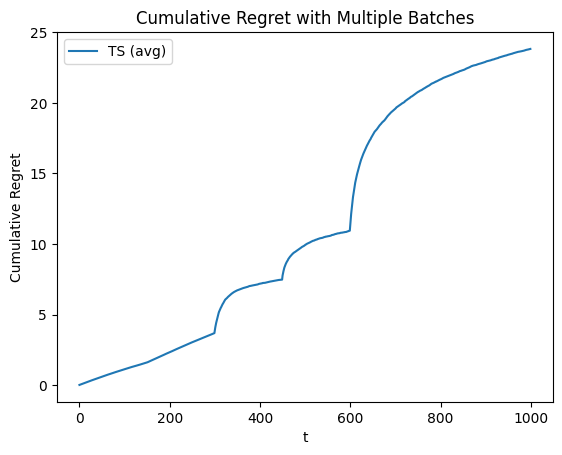

In [30]:
# Cumulative regret (mean over n runs)
plt.figure()
plt.plot(res["mean_cum_regret"], label="TS (avg)")
plt.xlabel("t")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret with Multiple Batches")
plt.legend()
plt.show()

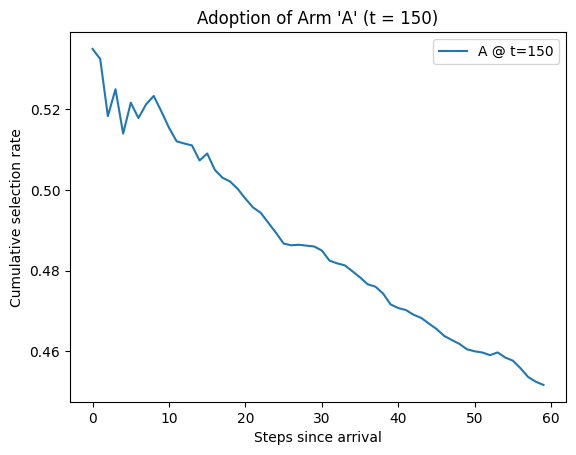

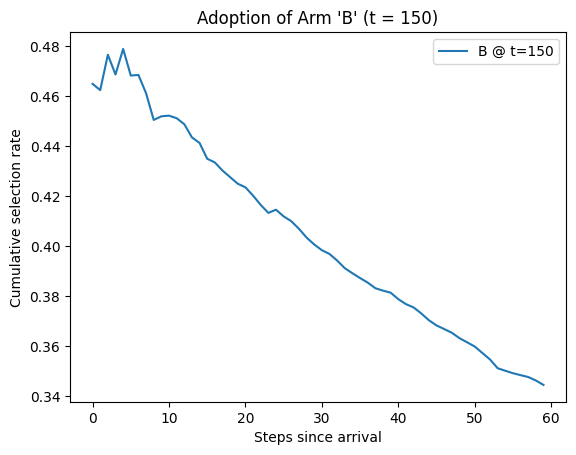

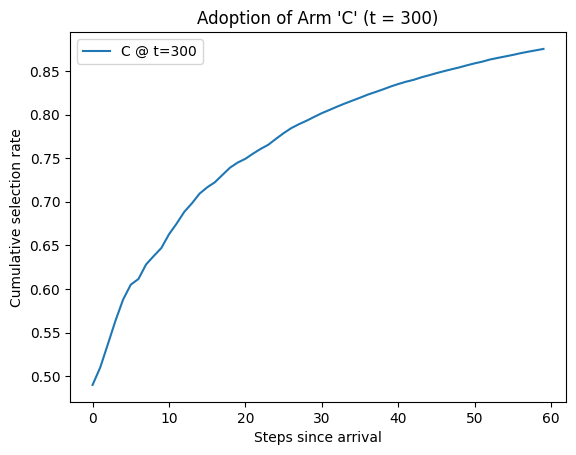

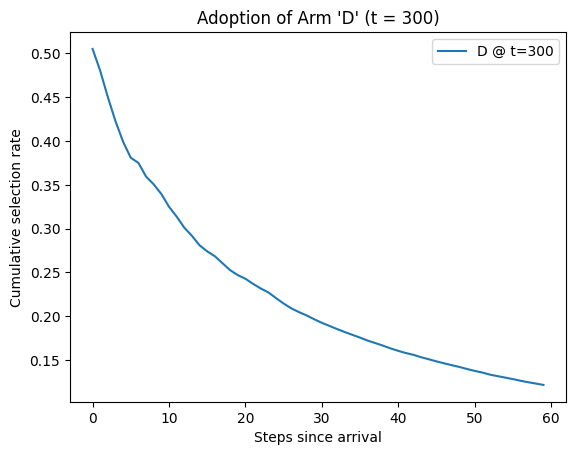

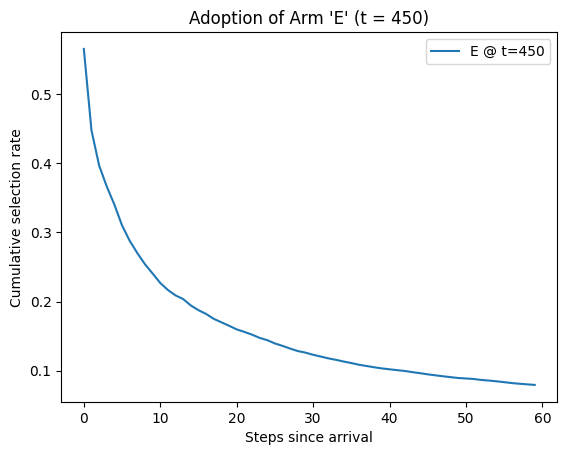

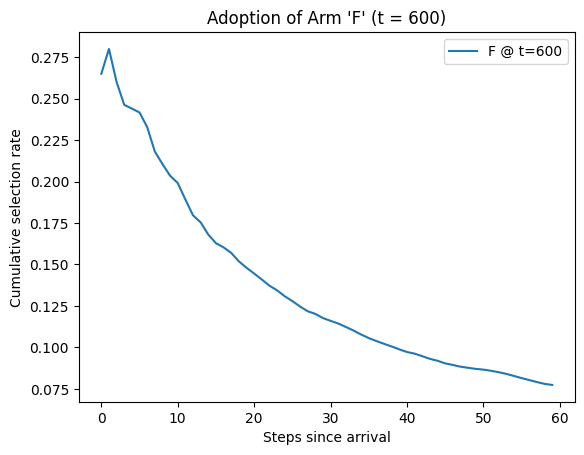

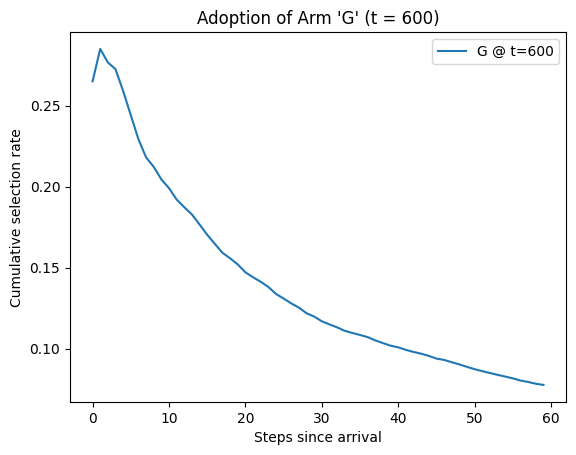

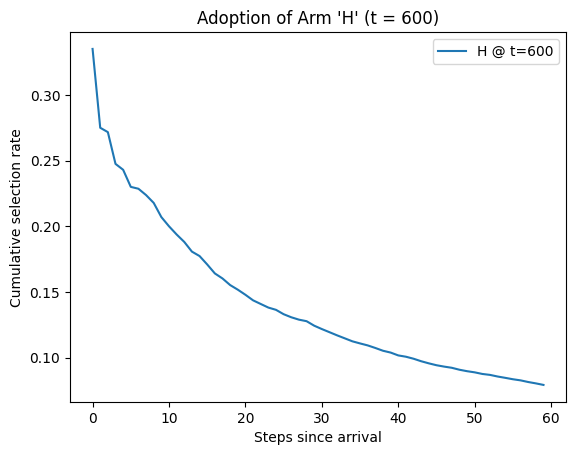

In [31]:
# Adoption plots (mean over n runs)
for t0, j, label in res["new_arm_meta"]:
    series = res["adoption_avg"][(t0, j)]
    plt.figure()
    plt.plot(np.arange(len(series)), series, label=f"{label} @ t={t0}")
    plt.xlabel("Steps since arrival")
    plt.ylabel("Cumulative selection rate")
    plt.title(f"Adoption of Arm '{label}' (t = {t0})")
    plt.legend()
    plt.show()

In [32]:
rows = []
W = res["window_w"]
for t0, j, label in res["new_arm_meta"]:
    series = res["adoption_avg"][(t0, j)]
    rows.append(
        {
            "Arrival t0": t0,
            "Label": label,
            "Avg discovery lag": res["avg_lag"][(t0, j)],
            f"Expected pulls in first {W} steps": series[-1] * W,
        }
    )

pl.DataFrame(rows).sort(by=["Arrival t0", "Label"])

Arrival t0,Label,Avg discovery lag,Expected pulls in first 60 steps
i64,str,f64,f64
150,"""A""",0.665,27.1
150,"""B""",0.84,20.665
300,"""C""",0.825,52.515
300,"""D""",1.075,7.305
450,"""E""",0.84,4.77
600,"""F""",1.915,4.64
600,"""G""",1.89,4.66
600,"""H""",1.975,4.755
